In [1]:
import numpy as np
import matplotlib.pyplot as plt
import arrow
import datetime
import xarray as xr
import os
import cmocean.cm as cm
import matplotlib.cm as cma
import scipy.interpolate as interp
from matplotlib.collections import PatchCollection
import matplotlib.dates as mpl_dates
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FormatStrFormatter
import datetime as dt
import pandas as pd
import matplotlib.dates as mpl_dates
import scipy.stats as stats

### Functions

In [2]:
#Function to extract data from 1 section
def get_secdata(datafile,sectionnum):
    
    variables = ['final_salt','final_transp','final_lon','final_lat','final_depth','final_section','final_z','final_temp','init_lon','init_z','init_salt','init_temp','init_transp','final_age']
    
    dict_var = {}
    
    idx = np.where(datafile['final_section']==sectionnum)
    
    for var in variables:
        if var == 'final_age':
            agetd = datafile[var].values
            agehr = agetd.astype('float64')/(10**9*3600)
            age = agehr[idx]
            dict_var[var] = age
        else:
            data_sec = datafile[var]
            dict_var[var] = data_sec[idx]
        
    
    return dict_var

def plotCS(axv,lonsec,zsec,transpsec,lonW,lonE,latgridi,depi,vmax,time,title,cblabel,ylabel):
    
    latgridf = latgridi-1
    fmask = mesh.fmask[0, :, latgridf]
    tmask = mesh.tmask[0]
    
    lons = data.init_lon[(data.final_section != 0)]
    
    f_lons = mesh.glamf[0, latgridf]
    u_lons = mesh.glamv[0, latgridf]
    w_depths = mesh.gdepw_1d

    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    cmap = cm.deep
    
    arr,xe,ye,im = axv.hist2d(lonsec/m2lon,df(zsec)[0],weights=transpsec,cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]],
                              density=True,vmax=vmax
                                )
    
    X,Y = np.meshgrid(xe,ye)
    
    im = axv.pcolormesh(X,Y,arr.T*np.sum(transpsec/time).values,cmap=cmap,vmax=vmax)
    
    axv.invert_yaxis()
    axv.set_title(title)
    axv.set_xlabel('Longitude (°E)')
    axv.set_xticks(np.linspace(f_lons[lonW+2]/m2lon,f_lons[lonE-2]/m2lon,2))
    axv.xaxis.set_major_formatter(FormatStrFormatter(f"%.{2}f"))
    axv.set_xticklabels(['{:.2f}'.format(label) for label in np.linspace(f_lons[lonW+2],f_lons[lonE-2],2)])
    axv.set_xticklabels(np.round(np.linspace(f_lons[lonW+2],f_lons[lonE-2],2),2))
    
    pc = draw_patches(fmask, lonW, lonE, np.array(u_lons), np.array(w_depths[0]),m2lon)
    axv.add_collection(pc)

    if cblabel == True:
        cb = fig.colorbar(im,ax=axv)
        cb.set_label('Transport (m/s)')
    
    if ylabel == True:
        axv.set_ylabel('Depth (m)')
        
    else: 
        axv.set_yticklabels([])

def plotTS(axn,var,lonsec,zsec,varsec,lonW,lonE,latgridi,depi,time,title,cblabel,ylabel,vmin=None,vmax=None):
    
    latgridf = latgridi-1
    fmask = mesh.fmask[0, :, latgridf]
    tmask = mesh.tmask[0]
    
    lons = data.init_lon[(data.final_section != 0)]
    
    f_lons = mesh.glamf[0, latgridf]
    u_lons = mesh.glamv[0, latgridf]
    w_depths = mesh.gdepw_1d

    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    cmap = cm.deep
    
    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    arrw,xe,ye,im = axn.hist2d(lonsec/m2lon,df(zsec)[0],weights=varsec,cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]])
    arrnw,xe2,ye2,im2 = axn.hist2d(lonsec/m2lon,df(zsec)[0],cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]])
    
    arr3 = arrw/arrnw
    
    X,Y = np.meshgrid(xe,ye)
    
    im = axn.pcolormesh(X,Y,arr3.T,vmin=vmin,vmax=vmax)
    axn.set_xlabel('Longitude (°E)')
    axn.set_title(title)
    axn.invert_yaxis()
    axn.set_xticks(np.linspace(f_lons[lonW]/m2lon,f_lons[lonE-1]/m2lon,2))
    axn.set_xticklabels(['{:.2f}'.format(label) for label in np.linspace(f_lons[lonW],f_lons[lonE-1],2)])
    
    if cblabel == True:
        cb = fig.colorbar(im,ax=axn)
        
        if var == 'temp':
            cb.set_label('Temperature (°C)')
        if var == 'sal':
            cb.set_label('Salinity (g/kg)')
            
    if ylabel == True:
        axn.set_ylabel('Depth (m)')
    else:
        axn.set_yticks([])
        
def get_datat(datafile,section, starttime, endtime):
    final_section = datafile.final_section
    final_transport = datafile.final_transp
    transports = np.sum(np.where(final_section == section, final_transport, 0)) 
    return transports/(endtime-starttime+1)

def running_mean(data, window_size):
    cumsum = np.cumsum(data)
    cumsum[window_size:] = cumsum[window_size:] - cumsum[:-window_size]
    return cumsum[window_size - 1:] / window_size

def draw_patches(fmask, ll, ul, u_lons, w_depths,m2lon):
    topo = []
    for i in range(ll, ul):
        for j in range(39):
            if fmask[j, i] == 0:
                try:
                    rect = Rectangle((u_lons[i]/m2lon, w_depths[j+1]), u_lons[i+1]/m2lon-u_lons[i]/m2lon, w_depths[j+2]-w_depths[j+1])
                    topo.append(rect)
                except:
                    pass

    pc = PatchCollection(topo, facecolors='lightgray', edgecolors='none')
    return(pc)

In [3]:
def plotCS2(axv,lonsec,zsec,transpsec,lonW,lonE,latgridi,depi,vmax,time,title,cblabel,ylabel):
    
    latgridf = latgridi-1 #actually lon
    fmask = mesh.fmask[0,:,:,latgridf] # Giving mask of longitudes
    tmask = mesh.tmask[0]
    
    lons = data.init_lat[(data.final_section != 0)]
    
    f_lons = mesh.gphif[0,:, latgridf]
    u_lons = mesh.gphiv[0,:, latgridf]
    w_depths = mesh.gdepw_1d

    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    cmap = cm.deep
    
    arr,xe,ye,im = axv.hist2d(lonsec/m2lon,df(zsec)[0],weights=transpsec,cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]],
                              density=True,vmax=vmax
                                )
    
    X,Y = np.meshgrid(xe,ye)
    
    im = axv.pcolormesh(X,Y,arr.T*np.sum(transpsec/time).values,cmap=cmap,vmax=vmax)
    
    axv.invert_yaxis()
    axv.set_title(title)
    axv.set_xlabel('Latitude (°W)')
    axv.set_xticks(np.linspace(f_lons[lonW+2]/m2lon,f_lons[lonE-2]/m2lon,2))
    axv.xaxis.set_major_formatter(FormatStrFormatter(f"%.{2}f"))
    axv.set_xticklabels(['{:.2f}'.format(label) for label in np.linspace(f_lons[lonW+2],f_lons[lonE-2],2)])
    axv.set_xticklabels(np.round(np.linspace(f_lons[lonW+2],f_lons[lonE-2],2),2))
    
    pc = draw_patches(fmask, lonW, lonE, np.array(u_lons), np.array(w_depths[0]),m2lon)
    axv.add_collection(pc)

    if cblabel == True:
        cb = fig.colorbar(im,ax=axv)
        cb.set_label('Transport (m/s)')
    
    if ylabel == True:
        axv.set_ylabel('Depth (m)')
        
    else: 
        axv.set_yticklabels([])

### Import data

In [4]:
data = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/for_jan18/for_straight_01jan18_s7t28/ariane_positions_quantitative.nc')
mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')

lonW = 308
lonE = 327
latgridi = 300
latgridf = latgridi-1
fmask = mesh.fmask[0, :, latgridi]
tmask = mesh.tmask[0]
    
lons = data.init_lon[(data.final_section != 0)]
    
f_lons = mesh.glamf[0, latgridi]
u_lons = mesh.glamv[0, latgridi]
w_depths = mesh.gdepw_1d

m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m

df = interp.interp1d(mesh.z,mesh.gdepw_1d) # Interpolate to get same binning scheme as SalishSeaCast

In [5]:
#Importing data and calculating section transport 
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

files = ['backVS_jan18','forharoVS_jan18']
namen = ['datafvs']

starttime = 1
endtime = 24
sectionnum = [0,1,2,3,4,5,6]

date = dt.datetime(2019,1,1)
enddate = dt.datetime(2019,12,31)

dates = []
datelist_vs = []

while date <= enddate:
    dates.append(date.strftime('%d%b%y').lower())
    datelist_vs.append(date)
    date+=dt.timedelta(days=1)
     
dicts = {}

for i,file in enumerate(files):
    dict_i = {}
    
    for date in dates:
        name = '/ocean/cstang/MOAD/analysis-camryn/Ariane/' + file + '/for_straight_' + date + '_s1t21/ariane_positions_quantitative.nc'
        
        if os.path.isfile(name):
            dict_i[date] = xr.open_dataset(name)
        
    dicts[file] = dict_i
    
dict_sectiontransp = {}

for file in files:
    st_dict = {}
    for var in dicts[file].keys():
        if var not in st_dict:
            st_dict[var] = []
        for section in sectionnum:
            st_dict[var].append(get_datat(dicts[file][var],section,starttime,endtime))
        dict_sectiontransp[file] = st_dict

dict_age = {}

for file in files:
    a_dict = {}
    
    for date in dicts[file].keys():
        if date not in a_dict:
            a_dict[date] = []
        for section in sectionnum:
            allvar = get_secdata(dicts[file][date],section)
            a_dict[date].append(np.mean(allvar['final_age'][allvar['final_age']>=24]))
    dict_age[file] = a_dict

age_2018 = {}

for file in files:
    
    if file not in age_2018:
        age_2018[file] = {}
    
    for section in sectionnum:
        
        if section not in age_2018[file]:
            
            age_2018[file][section] = []
            
        for date in dicts[file].keys():
            
            age_2018[file][section].append(dict_age[file][date][section])
            
transp_2018 = {}

for file in files:
    
    transp_2018[file] = []
    
    for date in dates:
        try:
            transp_2018[file].append(np.sum(dict_sectiontransp[file][date][2:]))
        except:
            pass
        
sectransp_2018 = {}

for file in files:
    sectransp_2018[file] = {}
    
    for section in sectionnum:
        if section not in sectransp_2018[file]:
            sectransp_2018[file][section] = []
            
        for date in dates:
            try:
                sectransp_2018[file][section].append(dict_sectiontransp[file][date][section])
            except:
                pass


### Shifting functions

In [6]:
def shift_time(dfr,dfr_age,datelist,base,factor):
    shifted_time = [date + dt.timedelta(days=base+factor*dfr_age[i]/24) for i,date in enumerate(datelist)]
    dfr = pd.DataFrame({'Transport':dfr.values,'Shifted_Time': shifted_time},index=dfr.index)
    return dfr

In [7]:
def merge(dfr,dfr2):
    """Aligns shifted dateframes to calculate correlation

    Args:
        dfr : Forward dataframe
        dfr2 (_type_): Backward dataframe

    Returns:
        _type_: Aligned, shifted dataframes and correlation between the 2.
    """
    
    oidx = dfr.index
    ndfr = dfr.set_index('Shifted_Time')
    nidx = ndfr.index
    
    step1 = ndfr.reindex(nidx.union(oidx)) # Creates dataframe with row of each old and new index ( no overlap - 128 rows now)
    step2 = step1.sort_index() # Sorts into chronological order
    step3 = step2.interpolate(axis=0) # Interpolates in between (since dates dont line up)
    fdfr = step3
    
    #Same for 2nd dataframe
    oidx2 = dfr2.index
    ndfr2 = dfr2.set_index('Shifted_Time')
    nidx2 = ndfr2.index
    
    step1 = ndfr2.reindex(nidx2.union(oidx2))
    step2 = step1.sort_index()
    step3 = step2.interpolate(axis=0)
    fdfr2 = step3
    
    corr = fdfr.Transport.corr(fdfr2.Transport) #Correlation ignores nan values
    
    avg = 0.5*(fdfr.Transport + fdfr2.Transport)
    return fdfr,fdfr2,corr,avg

#### Look at shift with Haro

### Importing tidal and density difference data

In [33]:
# Importing density and tidal data

density = pd.read_csv('sigma_2018_202111_mean.csv')
dens_diff = np.array(density.south - density.north)
date_dens = pd.to_datetime(density['Unnamed: 0'])

density_ros = pd.read_csv('sigma_2018_rosariovs_202111_mean.csv')
dens_diff_ros = np.array(density_ros.south - density_ros.north)
density_haro = pd.read_csv('sigma_2018_harovs_202111_mean_v2.csv')
dens_diff_haro = density_haro.south - density_haro.north
density_rosfpr = pd.read_csv('sigma_2018_rosariopr_202111_mean.csv')
dens_diff_rosfpr = density_rosfpr.north - density_rosfpr.south # north/south swapped for this one
density_harofpr = pd.read_csv('sigma_2018_haropr_202111_mean.csv')
dens_diff_harofpr = density_harofpr.north - density_harofpr.south # north/south swapped for this one
density_rosfprv2 = pd.read_csv('sigma_2018_rosariopr_202111_mean.csv')
dens_diff_rosfprv2 = density_rosfprv2.north - density_rosfprv2.south

tides = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/notebooks/low_pass_tide_VS.csv')

date = dt.datetime(2017,1,1)
enddate = dt.datetime(2022,12,31)
datelist_tides = []

while date <= enddate:
    datelist_tides.append(date)
    date+=dt.timedelta(days=1)

#Confirm dates are same length

print(len(datelist_tides))
print(tides.iloc[:,1].shape)   
 
date = dt.datetime(2017,1,1)
enddate = dt.datetime(2019,12,31)
datelist_dens = []

while date <= enddate:
    datelist_dens.append(date)
    date+=dt.timedelta(days=1)

#Confirm that the lengths are the same
print(len(datelist_dens))
print(date_dens.shape)

2191
(2191,)
1095
(1095,)


### Surface waters (from Haro to VS)

In [19]:
HarotoVSbl = sectransp_2018['backVS_jan18'][6]
HarotoVSl = sectransp_2018['forharoVS_jan18'][6]

HarotoVS = pd.Series(HarotoVSl,index=datelist_vs)
HarotoVSb = pd.Series(HarotoVSbl,index=datelist_vs)

In [10]:
# Loop through different base and factors to find which combination maximizes the correlation

factor_arr = np.arange(-1,1,0.05)
base_arr = np.arange(-1,1,0.05)

corr_arr = np.zeros([len(base_arr),len(factor_arr)])

for i,base in enumerate(base_arr):
    for j,factor in enumerate(factor_arr):
        dfr1 = shift_time(HarotoVS,age_2018['forharoVS_jan18'][6],datelist_vs,base,factor)
        dfr2 = shift_time(HarotoVSb,age_2018['backVS_jan18'][6],datelist_vs,-base,-factor)
        dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
        if corr_arr[i,j] > 0.52:
            print (base, factor, corr_arr[i, j])

-1.0 0.05000000000000093 0.5435298935242933
-1.0 0.10000000000000098 0.5435298935242933
-1.0 0.15000000000000102 0.5435298935242933
-1.0 0.20000000000000107 0.5435298935242933
-1.0 0.2500000000000011 0.5435298935242933
-1.0 0.30000000000000115 0.5427356994742286
-1.0 0.3500000000000012 0.5371354180224054
-0.95 8.881784197001252e-16 0.5435298935242933
-0.95 0.05000000000000093 0.5435298935242933
-0.95 0.10000000000000098 0.5435298935242933
-0.95 0.15000000000000102 0.5435298935242933
-0.95 0.20000000000000107 0.5435298935242933
-0.95 0.2500000000000011 0.5435298935242933
-0.95 0.30000000000000115 0.5428298841470833
-0.95 0.3500000000000012 0.5361422077467181
-0.8999999999999999 8.881784197001252e-16 0.5435298935242933
-0.8999999999999999 0.05000000000000093 0.5435298935242933
-0.8999999999999999 0.10000000000000098 0.5435298935242933
-0.8999999999999999 0.15000000000000102 0.5435298935242933
-0.8999999999999999 0.20000000000000107 0.5435298935242933
-0.8999999999999999 0.250000000000001

In [12]:
i_base_haros,i_factor_haros = np.where(corr_arr==np.max(corr_arr))

base_haros = base_arr[i_base_haros]
factor_haros = factor_arr[i_factor_haros]

print(base_arr[i_base_haros],factor_arr[i_factor_haros])

[0.95] [-0.45]


0.5567915004475501


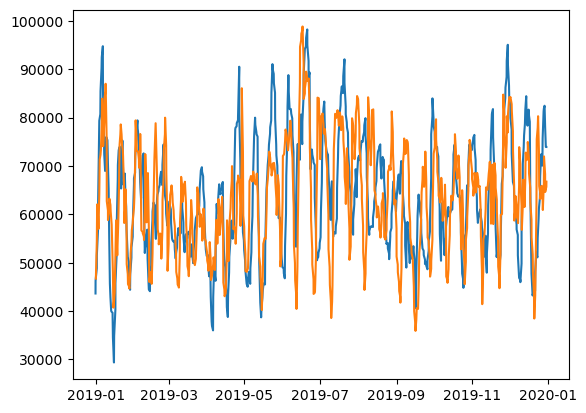

In [13]:
HarotoVS_sh = shift_time(HarotoVS,age_2018['forharoVS_jan18'][6],datelist_vs,base_arr[i_base_haros][0],factor_haros[0])
HarotoVSb_sh = shift_time(HarotoVSb,age_2018['backVS_jan18'][6],datelist_vs,-base_arr[i_base_haros][0],-factor_haros[0])

HarotoVS_m,HarotoVSb_m,c,HarotoVS_avg = merge(HarotoVS_sh,HarotoVSb_sh)
print(c)

plt.plot(HarotoVS_m.Transport)
plt.plot(HarotoVSb_m.Transport)

Text(0.5, 0, 'Base')

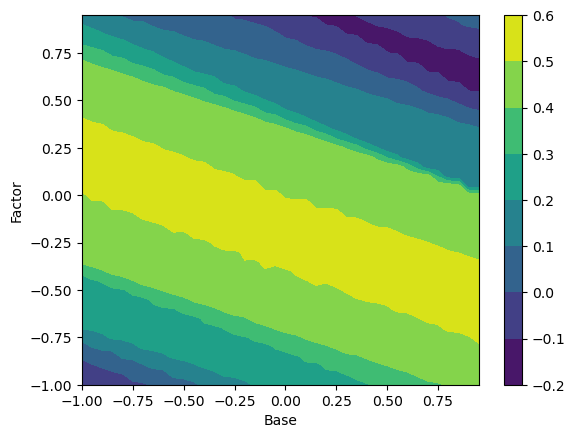

In [14]:
x,y = np.meshgrid(base_arr,factor_arr)

plt.contourf(x.T,y.T,corr_arr)
plt.colorbar()
plt.ylabel('Factor')
plt.xlabel('Base')

0.2780265811399062


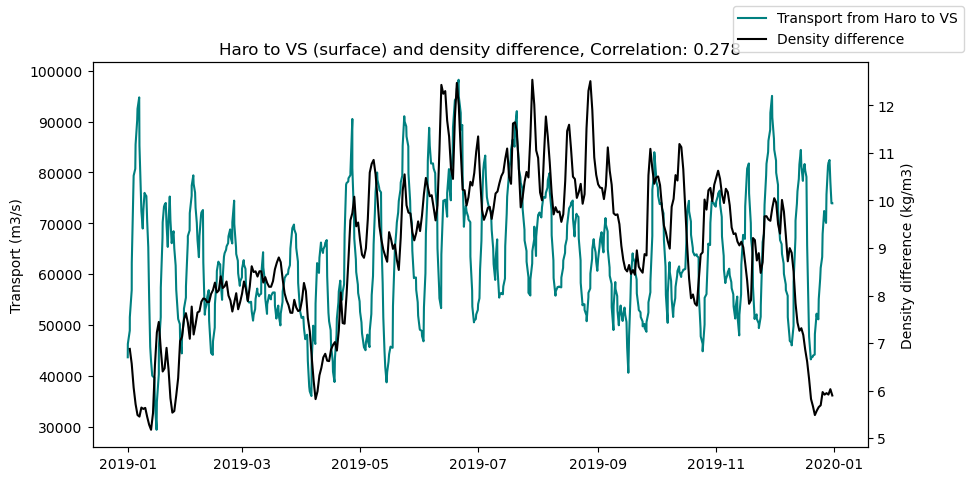

In [20]:
dateharo_sh = list(HarotoVS_avg.dropna().index)
mask = np.isin(datelist_dens,dateharo_sh)
densdiff_haro = dens_diff[mask]

fig,ax = plt.subplots(figsize=(10,5))

ax.plot(HarotoVS_m.dropna(),label='Transport from Haro to VS',color='teal')
ax2 = ax.twinx()
ax2.plot(np.array(datelist_dens)[mask],densdiff_haro,color='k',label='Density difference')
ax.set_ylabel('Transport (m3/s)')
ax2.set_ylabel('Density difference (kg/m3)')
fig.legend()

correlation,pvalue = stats.spearmanr(HarotoVS_avg.dropna(),densdiff_haro)
ax.set_title(f'Haro to VS (surface) and density difference, Correlation: {np.round(correlation,3)}')
print(correlation)

0.2780265811399062


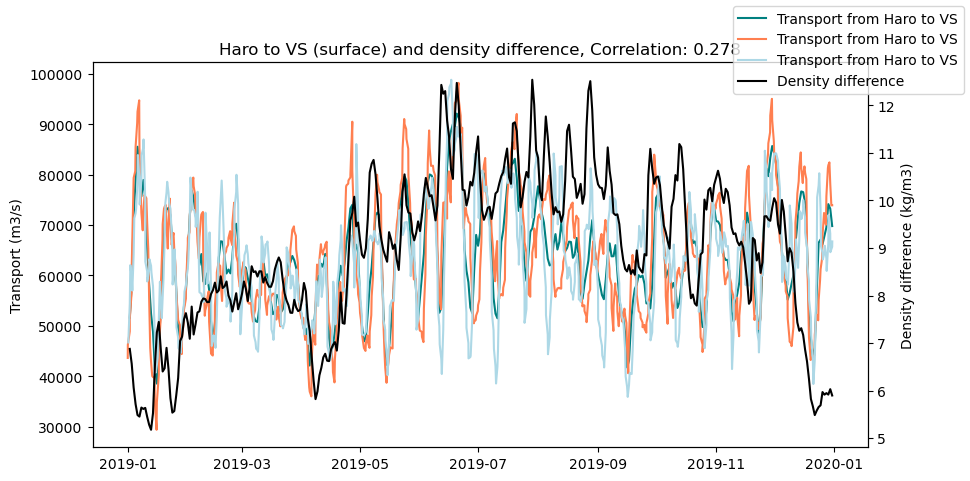

In [21]:
dateharo_sh = list(HarotoVS_avg.dropna().index)
mask = np.isin(datelist_dens,dateharo_sh)
densdiff_haro = dens_diff[mask]

fig,ax = plt.subplots(figsize=(10,5))

ax.plot(HarotoVS_avg.dropna(),label='Transport from Haro to VS',color='teal')
ax.plot(HarotoVS_m.dropna(),label='Transport from Haro to VS',color='coral')
ax.plot(HarotoVSb_m.dropna(),label='Transport from Haro to VS',color='lightblue')
ax2 = ax.twinx()
ax2.plot(np.array(datelist_dens)[mask],densdiff_haro,color='k',label='Density difference')
ax.set_ylabel('Transport (m3/s)')
ax2.set_ylabel('Density difference (kg/m3)')
fig.legend()

correlation,pvalue = stats.spearmanr(HarotoVS_avg.dropna(),densdiff_haro)
ax.set_title(f'Haro to VS (surface) and density difference, Correlation: {np.round(correlation,3)}')
print(correlation)

0.423830217105435


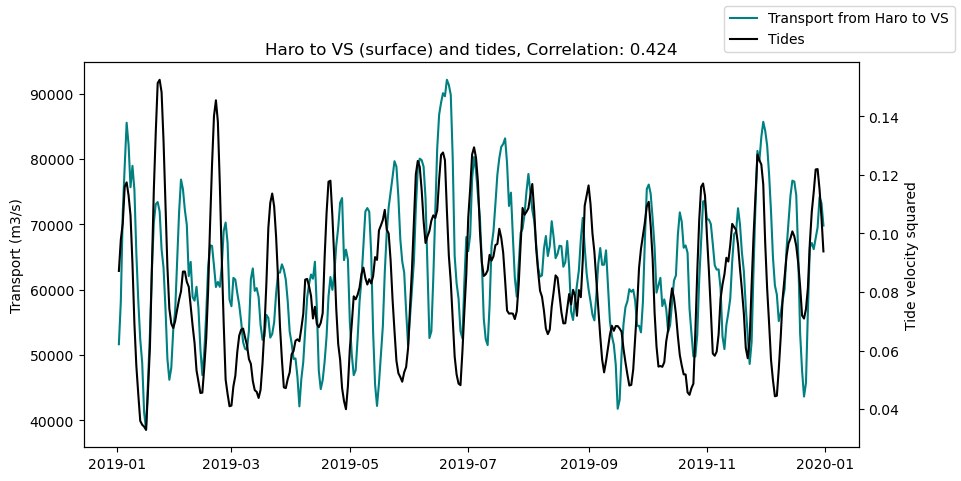

In [35]:
mask = np.isin(datelist_tides,dateharo_sh)
tides_haro = tides.vozocrtx[mask]

fig,ax = plt.subplots(figsize=(10,5))

ax.plot(HarotoVS_avg.dropna(),label='Transport from Haro to VS',color='teal')
ax2 = ax.twinx()
ax2.plot(np.array(datelist_tides)[mask],tides_haro,color='k',label='Tides')
ax.set_ylabel('Transport (m3/s)')
ax2.set_ylabel('Tide velocity squared')
fig.legend()

correlation,pvalue = stats.spearmanr(HarotoVS_avg.dropna(),tides_haro)
ax.set_title(f'Haro to VS (surface) and tides, Correlation: {np.round(correlation,3)}')
print(correlation)

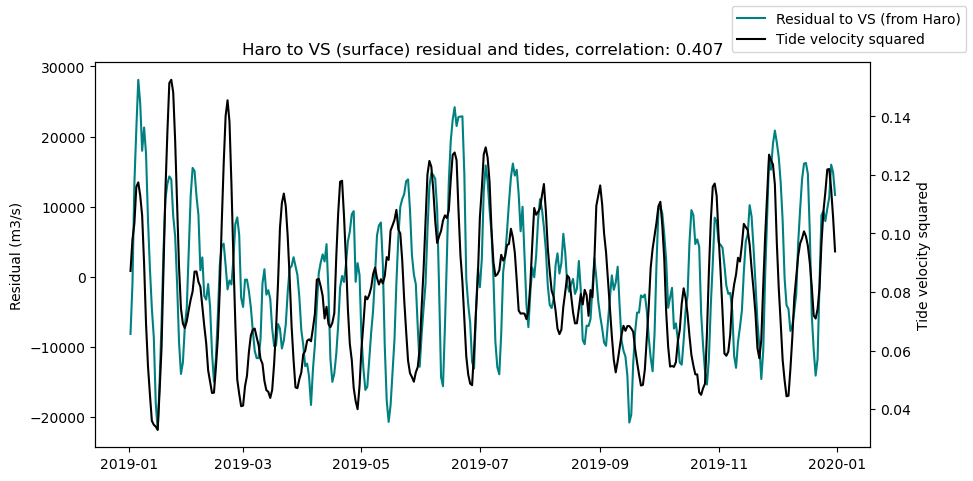

In [36]:
slope,intercept = np.polyfit(densdiff_haro,HarotoVS_avg.dropna(),1)

ddline_haro = slope*densdiff_haro+intercept
res_haro = HarotoVS_avg.dropna() - ddline_haro

corr,p = stats.spearmanr(tides_haro,res_haro)

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(res_haro,'teal',label='Residual to VS (from Haro)')
ax2=ax.twinx()
ax2.plot(dateharo_sh,tides_haro,color='k',label='Tide velocity squared')
ax.set_title(f'Haro to VS (surface) residual and tides, correlation: {np.round(corr,3)}')
ax.set_ylabel('Residual (m3/s)')
ax2.set_ylabel('Tide velocity squared')
fig.legend()


-0.027657563005927484


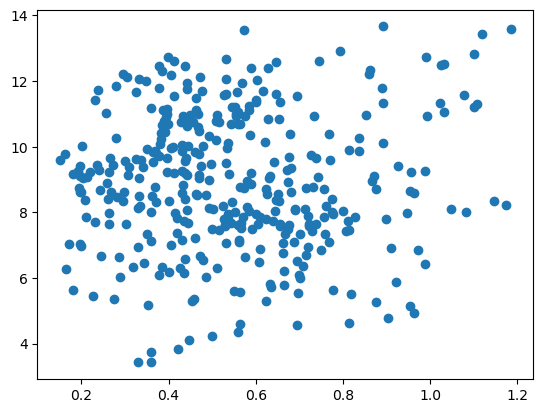

In [147]:
# Look at correlation between tides and density difference
corr,p = stats.spearmanr(tides_haro,densdiff_haro)
print(corr)
plt.scatter(tides_haro,densdiff_haro)